# Power issues in neuroscience and neuroimaging

### What is power ? 

Some notation and definition

* $H_0$ : null hypothesis: The effect we are testing for is null

* $H_A$ - alternative hypothesis : Not $H_0$

* $\alpha$ : false positive rate - probability to reject $H_0$ when $H_0$ is true (therefore $H_A$ is false)
* $\beta$ : false negative rate - probability to accept $H_0$ when $H_A$ is true ($H_0$ is false)
* $1 - \beta$ : power - probability we will reject $H_0$ if $H_A$ is true ($H_0$ is false)

**Power : definition**

power = $1-\beta$  ($\beta$ is the risk of false negative)

So, to compute power, *we need to know what is the risk of false negative*, ie, the risk to not show a significant effect while $H_A$ is true ($H_0$ is false).

Take the simple example of looking at the mean of an effect $\mu$, under some normal noise. Our statistic will be the estimated mean of the effect across our sample divided by the estimated standard deviation:

$$
t = \frac{\hat{\mu}}{\hat{{SE}_{\mu}}}
$$

Let's take a concrete example:

say that we have an 3% increase in our BOLD signal, per subject, such that the true $\mu$ is  $\mu = 3$.

Say that the noise level is known, and is exactly 9. So, $\sigma = 9$, $\sigma^2 = 81$ 

What is the chance of detecting that $\mu$ is greater than zero at the 5\% risk of error level ?

Power here would be the probability that the observed t is greater than $t_{.05}$, computing $t_{.05}$ by assuming that we are under the null. So, we compute $t_{.05}$ and ask ourselves what is $P(t > t_{.05})$. To compute this, __we need the distribution of our measured t when we know the signal !__ Let's assume we know it and call it $t_{nc}$, and $F_{nc}$ for the cumulative distribution (more on this in the appendix).

$Power = P(t > t_{.05}) = 1. - F_{nc}(t_{.05})$


This power will depend on three variablbes : $\mu$, $n$, and $\sigma$. In mathematical notations, $W = Power(\mu, n, \sigma)$

In [14]:
import scipy.stats as sst
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

In [57]:
# plot power as a function of n : define a little function that 
# takes n, mu, sigma, alpha, and report n. Optionally plot power as a function of n
from matplotlib.patches import Polygon

def stat_power(n=16, mu=1., sigma=1., plot=False, alpha=0.05, xlen=500):
    
    df = n-1
    theta = np.sqrt(n)*mu/sigma
    t_alph_null = sst.t.isf(alpha, df)
    ncrv = sst.nct(df, theta)
    spow = 1 - ncrv.cdf(t_alph_null)
    
    if plot:
        # define the domain of the plot
        norv = sst.norm(0, 1.)
        bornesnc = ncrv.isf([0.001, .999])
        bornesn = norv.isf([0.001, .999])
        # because the nc t will have higher max borne, and the H0 normal will be on the left
        x = np.linspace(np.min(bornesn), np.max(bornesnc), xlen)
        t_line = np.zeros_like(x)
        # define the line 
        x_t_line = np.argmin((x-t_alph_null)**2)
        y_t_line = np.max(np.hstack((ncrv.pdf(x), norv.pdf(x))))
        t_line[x_t_line] = y_t_line

        fig, ax = plt.subplots()
        plt.plot(x, ncrv.pdf(x), 'g', x, norv.pdf(x), 'b', x, t_line, 'r')
        
        # Make the shaded region
        # http://matplotlib.org/xkcd/examples/showcase/integral_demo.html
        a = x[x_t_line]; b =  np.max(bornesnc);
        ix = np.linspace(a,b)
        iy = ncrv.pdf(ix)
        verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
        poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
        ax.add_patch(poly)
        
        ax.set_xlabel("t-value - H1 centred on " + r"$\theta $" + " = %4.2f;  " %theta 
                      + r"$\mu$" + " = %4.2f" %mu); 
        ax.set_ylabel("Probability(t)");
        ax.set_title('H0 and H1 sampling densities ' 
                     + r'$\beta$' + '= %3.2f' %spow + ' n = %d' %n)
        plt.show()

    return spow


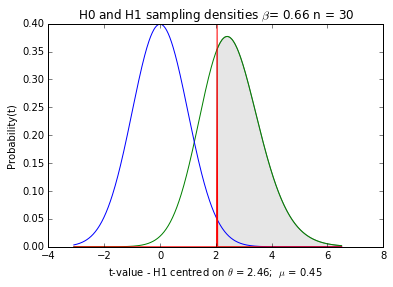

0.66369123698129817

In [58]:
n = 30
mu = .45
sigma = 1.
stat_power(n, mu, sigma, plot=True, alpha=0.025, xlen=500)


The reason why the alternative hypothesis H1 is not centred on $\mu$ is that the normalised effect under H1 (the effect that has standard deviation of 1) is : $$\theta = \frac{\mu\sqrt{n}}{\sigma}$$


In [59]:
pw = [stat_power(n, mu, sigma) for n in range(7, 77, 3)]    

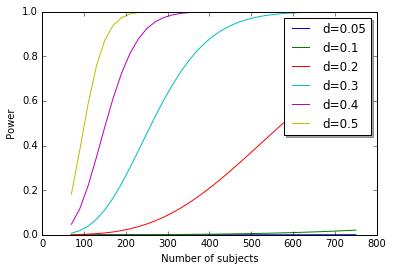

In [60]:
muse = (.05, .1,.2,.3,.4,.5);
mstr = [ 'd='+str(m) for m in muse]
nses = range(70, 770, 20); lines=[]
alpha = 1.e-6

for mu in (muse):
    pw = [stat_power(n, mu, sigma, alpha=alpha, plot=False) for n in nses]    
    (pl,) = plt.plot(nses, pw)
    lines.append(pl)
plt.legend( lines, mstr, loc='upper right', shadow=True) # 'upper right', is default
plt.xlabel(" Number of subjects ")
plt.ylabel(" Power ");

### Cohen's d value:

Cohen's d value simply normalize the sigma such that it is one. in the example above, cohen's d are simply :

In [61]:
# print some cohen values
sigmas = np.linspace(1.,.5,len(muse))
cohenstr = ["For sigma = %3.2f and m = %3.2f Cohen d = %3.2f" %(sig,mu,coh) 
       for (sig,mu,coh) in zip(sigmas,muse, np.asarray(muse)/sigmas)]
for s in cohenstr:
    print(s)

For sigma = 1.00 and m = 0.05 Cohen d = 0.05
For sigma = 0.90 and m = 0.10 Cohen d = 0.11
For sigma = 0.80 and m = 0.20 Cohen d = 0.25
For sigma = 0.70 and m = 0.30 Cohen d = 0.43
For sigma = 0.60 and m = 0.40 Cohen d = 0.67
For sigma = 0.50 and m = 0.50 Cohen d = 1.00


From https://en.wikipedia.org/wiki/Cohen%27s_d#Cohen.27s_d :

"For Cohen's d an effect size of 0.2 to 0.3 might be a "small" effect, around 0.5 a "medium" effect and 0.8 to infinity, a "large" effect.[7]:25 (But note that the d might be larger than one.)
Cohen's text[7] anticipates Lenth's concerns:"

"The terms 'small,' 'medium,' and 'large' are relative, not only to each other, but to the area of behavioral science or even more particularly to the specific content and research method being employed in any given investigation....In the face of this relativity, there is a certain risk inherent in offering conventional operational definitions for these terms for use in power analysis in as diverse a field of inquiry as behavioral science. This risk is nevertheless accepted in the belief that more is to be gained than lost by supplying a common conventional frame of reference which is recommended for use only when no better basis for estimating the ES index is available."


## From Button et al. : three messages

### message1 : studies of low power have low probability of detecting an effect

#### From the definition of power !

### message2 : studies of low power have low positive predictive value : PPV = P(H1 True | detection)

Same as Ioannidis : 
Say that $H_1$ is the event that the alternative hypothesis is true, 
that $H_0$ is the event that the null hypothesis is true, $P_1 = P(H_1), P_0 = P(H_0)$, $D$ is the event of detection and $N$ is the event of no detection. 

From Button et al., we have the positive predictive value PPV defined as :

$$
PPV = \frac{(1-\beta)R}{(1-\beta)R + \alpha},\textrm{ with } R = P(H_1)/P(H_0) = P_1 / P_0
$$

Hence, 

$$
PPV = \frac{(1-\beta)P_1}{P_0}\frac{P_0}{(1-\beta)P_1 + \alpha P_0} 
$$

$$
= \frac{(1-\beta)P_1}{(1-\beta)P_1 + \alpha P_0} 
$$

$$
= P(H_1, D) / P(D) = P(H_1 | D) 
$$

If we have 4 chances over 5 that $H_0$ is true, and one over five that $H_1$ true, then R = 1/5 / 4/5 = .25. If there's 30% power we have PPV = 50%. So, 50% chance that our result is indeed true. 80% power leads to 80% chance. 

In [62]:
def PPV(R, Pw, alpha, verbose=True):
    ppv = (Pw * R)/(Pw*R + alph)
    if verbose:
        print("with odd ratio=%3.2f, "
               "power=%3.2f, alpha=%3.2f,"
               "PPV=%3.2f" %(R,Pw,alph,ppv))
    return ppv
    

In [63]:
# example from Button et al: P1 = 1/5, P0 = 4/5. R = 1/4
R = 1./4.
Pw = .8
alph = .05
PPV(R, Pw, alph)

with odd ratio=0.25, power=0.80, alpha=0.05,PPV=0.80


0.8

In [64]:
# if power is small :
R = 1./4.
Pw = np.arange(.1,1,.2)
alph = .05
for pw in Pw:
    PPV(R, pw, alph)


with odd ratio=0.25, power=0.10, alpha=0.05,PPV=0.33
with odd ratio=0.25, power=0.30, alpha=0.05,PPV=0.60
with odd ratio=0.25, power=0.50, alpha=0.05,PPV=0.71
with odd ratio=0.25, power=0.70, alpha=0.05,PPV=0.78
with odd ratio=0.25, power=0.90, alpha=0.05,PPV=0.82


### message3 : studies of low power exagerate the effect size of claimed effects

If the power is small, the studies that will find an effect significant will be estimating a stronger effect than the true one. Let's simulate the phenomenon.

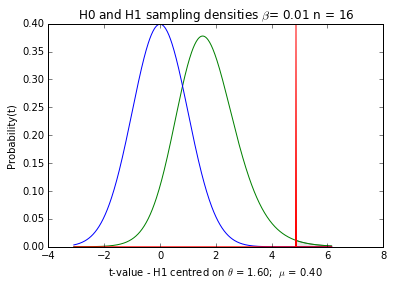

0.00724395962824


In [65]:
n = 16 # number of subjects
sigma = 1.0
mu = .4
alpha = .0001
pw = stat_power(n, mu, sigma, alpha=alpha, plot=True)
print(pw)

In [66]:
Nexp = 100

norv = sst.norm(0., sigma)
strv = sst.t(n-1)
t_05 = strv.isf(.05)
sample = norv.rvs(size=(n,1)) + mu
#print np.std(sample)

tval = np.zeros((Nexp,))
effects = np.zeros((Nexp,))
effectsize = np
nb_detection = 0
for e in range(Nexp):
    sample = norv.rvs(size=(n,1)) + mu
    tval[e] = sample.mean()*np.sqrt(n)/np.std(sample, ddof=1)
    effects[e] = sample.mean()/np.std(sample, ddof=1)

relbias = 100*(effects[tval > t_05].mean() - mu)/mu
print("mean effect", effects.mean())
print("mean effect when test significant", effects[tval > t_05].mean())

print("relative bias: %3.2f " % relbias)

estimated_effect = effects[tval > t_05].mean()

mean effect 0.400616762548
mean effect when test significant 0.642764674485
relative bias: 60.69 


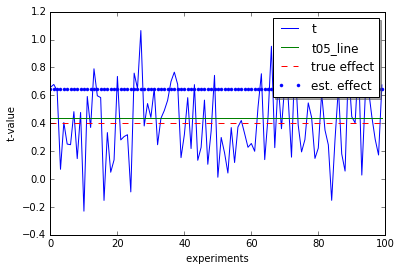

In [67]:
x = range(Nexp)
t05_line = np.ones_like(x)*t_05
true_effect = np.ones_like(x)*mu
est_effect = np.ones_like(x)*estimated_effect

lines = plt.plot(x, effects, 'b-', x, t05_line/np.sqrt(n), 'g-', 
             x, true_effect, 'r--', 
             x, est_effect, 'b.') 
plt.legend( lines, ('t','t05_line', 'true effect', 'est. effect'), 
                   loc='upper right', shadow=True)
plt.xlabel(" experiments ")
plt.ylabel(" t-value ")

In [68]:
from IPython.display import Image as Image

Another way of seeing the same thing in Button et al, 2013:

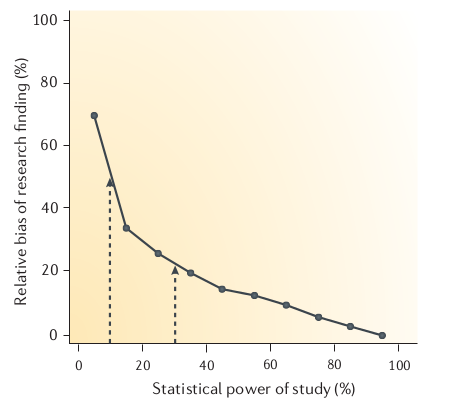

In [69]:
Image('./figures/button_fig5.png')

#### Replication should be done with more subjects, not the same amount. 

A graph which I found hard to understand, because in c under the null the variance of the distribution should be reduced as well.

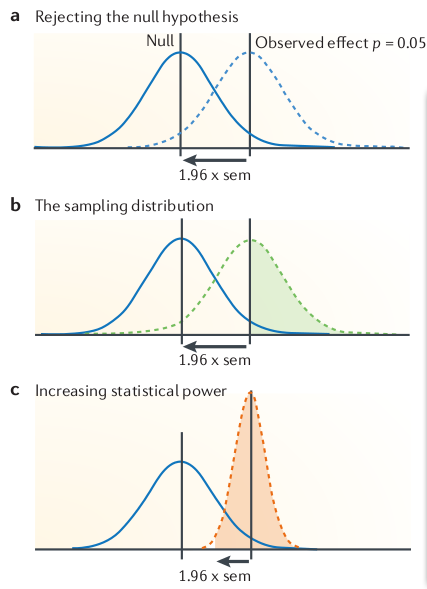

In [70]:
Image('./figures/button_fig1.png')

#### Looking at the median power study of 49 Meta analysis : median power of studies in those

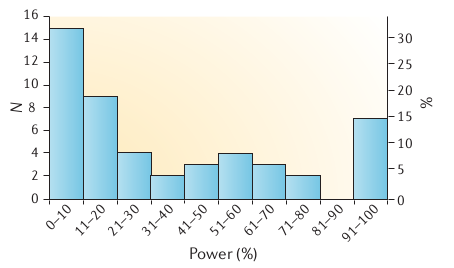

In [71]:
Image('./figures/button_fig2.png')

## Karl Friston 16 subjects magic number - Tal Yarkoni's answer

### Summary of the argument:

1.  The null is always false: no effects are ever truly zero. Collect enough data and you will always end up rejecting the null.

2.  Large effects are more important than small ones. Very small effects are ‘trivial’.

3.  Very large samples will invariably end up identifying many small uninteresting effects. We should sample few subjects to detect only the big effects.


In [72]:
# power of KF analysis : d=1, 
n = 16; mu = .25; sigma = 1.; alpha = 0.0001
stat_power(n, mu, sigma, alpha=alpha)

0.0017563644066647122

The problem of this argument:

1. We are in a less favorable case - eg p-values threshold are less than 0.05 because of MC, effect size are smaller

2. The uncertainty of small n results is very high. Confidence interval are just above zero.

3. Our prior is that effect sizes are small: 


### 1. A less favorable case

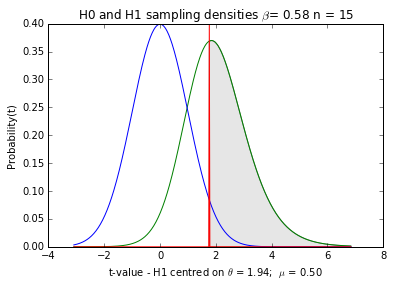

0.57805549003782641

In [73]:
# analysis in a slightly less favorable case 
n = 15; mu = .5; sigma = 1.; alpha = 0.05
stat_power(n, mu, sigma, plot=True, alpha = alpha)

#### We are doing many test and have to decrease $\alpha$ - 

What would be n for 80% in this situation ? Let's work out the formula - but let's do it with a normal approximation.

In [74]:
def n_power(pw=.8, mu=1., sigma=1., alpha=0.05):

    norv = sst.norm(0,1.)
    ta = norv.ppf(1 - alpha)
    tb = norv.ppf(1 - pw)
    n = (sigma*(ta - tb)/mu)**2
    return n


In [75]:
norv = sst.norm(0,1.)
ta = norv.ppf(.95)
ta

1.6448536269514722

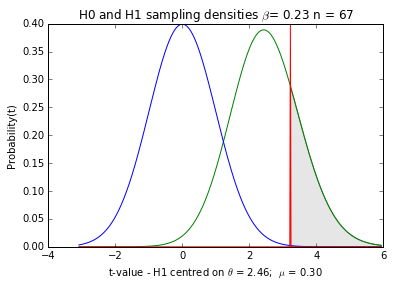

0.234920833838
171.771913977


In [76]:
mu = .3; sigma = 1.; alpha = 0.001; pw = .8
print(stat_power(67, mu, sigma, plot=True, alpha=alpha))
print(n_power(pw, mu, sigma, alpha=alpha))


So, in neuroimaging where our non corrected p-value needs to be small, let's plot n as a function of alpha :

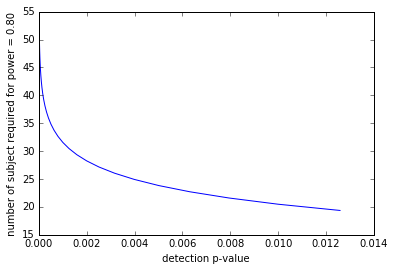

In [77]:
# assume cohen's d is .7
mu = .7; sigma = 1.; pw = .8

lnalph = np.arange(1.9,5.1,.1)
nsub = [n_power(pw, mu, sigma, alpha=10**(-a)) for a in lnalph]
x = 10**(-lnalph)
#print x
plt.plot(x, nsub)
plt.xlabel(' detection p-value ')
_ = plt.ylabel(' number of subject required for power = %3.2f ' % pw)
#xscale('log')

### 2. The uncertainty of small n results is very high. Confidence interval are just above zero.

In [78]:
"""
loc = np.pi
print(sst.t.ppf(0.025, 1000, loc, 1.))
print(sst.t.ppf(0.975, 1000, loc, 1.))
print(sst.t.ppf(0.05, 10, 0., 1.))
print(sst.nct.ppf(0.05, 10, 1., 1.))
""";


Power =  0.308927368051
Theoretical mean t value should be around 1.20 

t_alph, theta 2.13144954556 1.2
number of detections: (105,)
Lower confidence interval above actual mean: (lCI > mu)  0.02
Lower confidence interval below zezo:(lCI < 0) for dection should be zero:  0


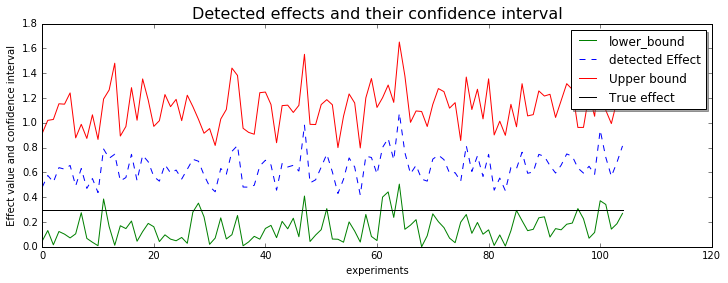

In [94]:
n = 16; mu = .3; sigma = 1.; alpha = 0.05
df = n-1
theta = mu*np.sqrt(n)/sigma

print('Power = ', stat_power(n, mu))
print("Theoretical mean t value should be around {:.2f} \n".format(theta))
print("t_alph, theta", t_alph, theta)

norv = sst.norm(0., sigma)
strv = sst.t(df)
t_alph = strv.isf(alpha/2)

# look at what the noncentral would have given:
# print("non central on theta", sst.nct.cdf(alpha/2., df, theta), 
#                               sst.nct.cdf(1.-alpha/2., df, theta))

# simulate Nexp experiments
Nexp = 500
t = np.zeros((Nexp,))
effect = np.zeros((Nexp,))
lCI = np.zeros((Nexp,))
uCI = np.zeros((Nexp,))

for e in range(Nexp):
    sample = norv.rvs(size=(n,)) + mu
    # effect and normalized effect size
    effect[e] = sample.mean()
    sigma_n = np.std(sample, ddof=1)/np.sqrt(n)  # Careful: np.std takes ddof as 
                                                 # the df of freedom lost! here: 1.
    t[e] = effect[e]/sigma_n
    # confidence interval :
    CI = sst.t.ppf(1.-alpha/2., df)*sigma_n
    lCI[e] = effect[e] - CI # t_alph # 
    uCI[e] = effect[e] + CI # t_alph # 

# number of detection:
detect = t>t_alph
x = np.arange(Nexp)
xd = np.arange(detect.sum())
print( 'number of detections:', xd.shape)

mu_line = np.ones((Nexp,))*mu

f = plt.figure(1).set_size_inches(12,4)
lines = plt.plot(xd, lCI[detect], 'g-', 
                 xd, effect[detect], 'b--',
                 xd, uCI[detect], 'r-',
                 xd, mu_line[detect], 'k');
plt.legend( lines, ('lower_bound','detected Effect', 'Upper bound', 'True effect'), 
                   loc='upper right', shadow=True)
plt.xlabel(" experiments ")
plt.ylabel(" Effect value and confidence interval ")
plt.title("Detected effects and their confidence interval", fontdict={'size':16})

#print the number of lower confidence interval values that are above the true mean:
# this should be about the risk of error
print("Lower confidence interval above actual mean: (lCI > mu) ", 
                                          (lCI > mu).sum() / (1.*Nexp))
# there should be none of these:
print("Lower confidence interval below zezo:(lCI < 0) for dection should be zero: ", 
                                          (lCI[detect] < 0).sum())



### 3. Our prior is that effect sizes are small

* big effects have been found
* big effect sizes are less likely than small ones :  the prior of big effects is low
* large sample studies report lower effects - as well as intra subjects

Example of Desmond and Glover 2002: using a threshold of 0.01, working memory task, 12 subject:

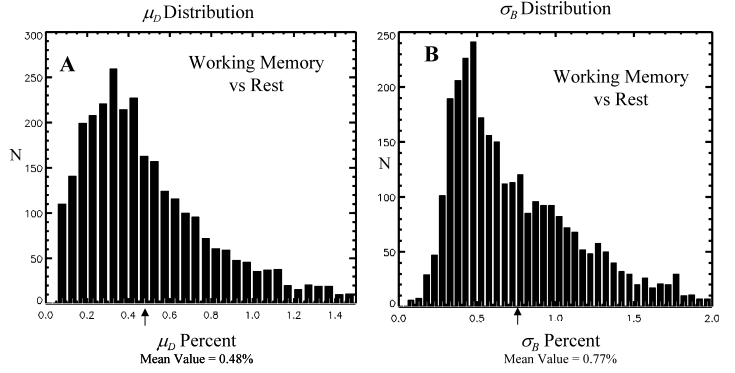

In [25]:
Image('./figures/Desmond_Glover_effectsize.png')

## References

Discussed directly in the notebook:
------------------------------------

Katherine S. Button, John P. A. Ioannidis, Claire Mokrysz1, Brian A. Nosek4,
Jonathan Flint5, Emma S. J. Robinson6 and Marcus R. Munafò. Power failure: why small sample
size undermines the reliability of neuroscience.

T. Yarkoni, 2012 [citation needed]» Blog Archive » Sixteen is not magic: Comment on Friston (2012)

Desmond and Glover, Estimating sample size in functional MRI (fMRI) neuroimaging
studies: Statistical power analyses, Journal of Neuroscience Methods 118 (2002) 115/128.

K. Friston, 2012, Neuroimage. Ten ironic rules for non-statistical reviewers


See also:
---------

Joseph P. Simmons, Leif D. Nelson and Uri Simonsohn. False-Positive Psychology: Undisclosed Flexibility in Data Collection and Analysis Allows Presenting Anything as Significant. Psychological Science. 2011.

C. Glenn Begley	 & Lee M. Ellis. Drug development: Raise standards for preclinical cancer research. Nature, 2012.

M Brandon Westover, Kenneth D Westover, Matt T Bianchi, 2011, BMC Medecine, Significance testing as perverse probabilistic reasoning.

and 

Carp, J. The secret lives of experiments: methods reporting in the fMRI literature. Neuroimage 63,
289–300 (2012).

This article reviews methods reporting and methodological choices across 241 recent fMRI
studies and shows that there were nearly as many unique analytical pipelines as there were studies. In
addition, many studies were underpowered to detect plausible effects.




Sander Heinsalu said:

    "Publication bias is a problem in all fields of research. The results of a paper should actually receive zero weight in the evaluation of its quality, otherwise there is the motivation to cherry-pick the data that give the most impressive result. The measure of quality should be the way the results were obtained – size of sample, experimental procedure, endpoints used. Ideally the reviewers of a paper should not see its results at all, only the description of the experiment."


## Appendix

### Karl Friston rules - and answers (K. Friston, 2012, Neuroimage)

Here only the 3 rules pointed out by T.Y. that seem more detrimental than helpful are discussed.


* Rule number four: the under-sampled study
         "your study is undersampled"
         
Answ: Results are stronger because a significant result (properly controlled for false positives), based on a small sample indicates the treatment effect is actually larger than the equivalent result with a large sample. In short, not only is our result statistically valid. It is quantitatively stronger than the same result with a larger number of subjects

* Rule number five: the over-sampled study
        "If I have to analyse 100 patients before finding a discernible effect, one has to ask whether this effect has any diagnostic or predictive value." 

No specific answer to this criticism.

* Rule number eight: exploit double dipping supersticious thinking
        "Report effect sizes based upon data (regions of interest) previously identified as significant in their whole brain analysis. This is not valid."

Answ : the effect size pertains to the data used to make an inference — and can be regarded as an in-sample prediction of the treatment effect.



### Derivation of the non central t stat :

If our observations are $y_i$ for say $n$ subjects, we estimate

$\hat{\mu} = \sum_{i=1}^n y_i /n = \bar{y}$

We suppose independent $y_i$ with $ y_i \sim N(\mu,\sigma^2) $ and want to test if $\mu = 0$. For the standard error of the estimated mean, if $\sigma$ is known, we have 

$Var(\hat{\mu}) = \frac{ \sum_{i=1}^n Var(y_i) }{n^2} =  \sigma^2$ / n

In general we dont know $\sigma$, and we need an estimate of it.  This is obtained with 

$$
\hat{\sigma^2} = \frac { \sum_{i=1}^n (y_i - \bar{y})^2 }{ n-1 } =  \frac{RSS}{n-1} =  \frac{n}{n-1} RMS
$$

The RSS is defined as $\sum_{i=1}^n (y_i - \bar{y})^2 $ and RMS : the residual mean square is defined as: $ \text{RMS} =  \frac{\sum_{i=1}^n (y_i - \bar{y})^2 }{n} $


$$ \hat{\sigma} = \hat{SE} = \sqrt{\frac{ n}{n - 1} RMS} $$

where $\hat{SE}$ is the "Standard Error".  So, eventually, we get our t statistics to be:

$$ 
t = \frac{ \bar{y}}{\sqrt{\frac{ n}{n - 1} RMS}}
$$

Now, lets find the *distribution* of t. 

We can rewrite t as 

$$ 
t = \frac{ \frac{\sum_i{y_i - \mu} }{\sqrt{n}\sigma} +  \sqrt{n}\mu/\sigma} { \sqrt{\frac{RSS}{(n - 1) \sigma^2}}}
$$

and since the $y_i$ are from $N(\mu,\sigma^2)$, we then realize that this is exactly the definition of a **non central t statistics** see [wikipedia](https://en.wikipedia.org/wiki/Noncentral_t-distribution). One thing we have not shown is the independance of the numerator and the denominator, but let's leave this aside.

Therefore this t value follows a non central t distribution with $n-1$ degrees of freedom and non centrality parameter $\theta = \mu \sqrt{n}/\sigma$. We are going to use this for our power analysis. Let's call this distribution probability density function $t_{nc,\theta,n-1}$, or $t_{nc}$, and its cumulative density function $F_{nc}$